In [1]:
import sys
sys.path.insert(0,'detectron2/projects/DensePose')

from pycocotools.coco import COCO
from detectron2.config import get_cfg
from densepose import add_densepose_config
from densePoseLoss import DensePoseLoss
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import torch
import torchvision
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
from detectron2.data.detection_utils import read_image
import numpy as np
import pandas as pd
import pickle
from torch.utils.tensorboard import SummaryWriter
import datetime
import albumentations as albu
from matplotlib import pyplot as plt

In [2]:
DEVICE = "cuda"
MARCUP_PATH = 'archive/densepose_coco_2014_train.json'
IMAGES_DIR = 'archive/train2014/train2014'
TEST_DIR = 'checker'
CONFIG_PATH = "config.yaml"
ENCODER = 'se_resnext50_32x4d' # 'timm-resnest26d' 'vgg16' 'se_resnext50_32x4d' 'se_resnext101_32x4d'
ENCODER_WEIGHTS = 'imagenet'

RANDOM_STATE = 42

https://github.com/facebookresearch/DensePose/blob/main/challenge/2018_COCO_DensePose/data_format.md - описание формата COCO

https://github.com/facebookresearch/DensePose/blob/main/PoseTrack/DensePose-PoseTrack-Visualize.ipynb - пример чтения датасета

https://github.com/qubvel/segmentation_models.pytorch#encoders - описание моделей

https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb - пример использования библиотеки

In [4]:
# split train and test

coco = COCO(MARCUP_PATH)

imgIds = coco.getImgIds()
imgs = np.array([
    img for img in coco.loadImgs(imgIds) 
    if not 'has_no_densepose' in img.keys()
])
ids = np.arange(len(imgs))

train_imgs, valid_imgs, train_ids, valid_ids = train_test_split(
    imgs, ids, train_size=0.95, random_state=RANDOM_STATE
)

loading annotations into memory...
Done (t=9.91s)
creating index...
index created!


In [7]:
def count_parameters(model, verbose=False):
    params_cnt = pd.Series({
        name: parameter.numel()
        for name, parameter in model.named_parameters() 
        if parameter.requires_grad
    })
    if verbose:
        print(params_cnt.to_string())
    return params_cnt.sum()

In [8]:
class AverageValueMeter():
    def __init__(self):
        self.reset()

    def add(self, value, n=1):
        self.sum += value
        self.n += n

    def value(self):
        return self.sum / self.n

    def reset(self):
        self.n = 0
        self.sum = 0.0
        

class CocoDataset(Dataset):
    
    def __init__(self, imagesDir, imgs=[], ids=[], preprocessing_fn=None, augmentation=None):
        
        self.preprocessing_fn = preprocessing_fn
        self.augmentation = augmentation
        self.imgs = imgs
        self.ids = torch.tensor(ids)
        self.imagesDir = imagesDir
        
        if len(self.imgs) == 0:
            self.list_files = list(filter(self.filter_jpg, os.listdir(imagesDir)))
            self.list_files.sort(key=lambda x: int(x.split('.')[0]))
        else:
            self.list_files = None
        

    @staticmethod
    def filter_jpg(file):
        file = file.rsplit('.', 1)
        if len(file) > 1:
            ext = file[1]
            return ext == 'jpg'
        return False
        
        
    def __getitem__(self, i):
        
        if self.list_files:
            imageName = self.list_files[i]
        else:
            imageAnn = self.imgs[i]
            imageName = imageAnn['file_name']            
        
        # predictor expects BGR image
        image = read_image(os.path.join(self.imagesDir, imageName), format="BGR") 

        # apply augmentations
        if self.augmentation:    
            sample = self.augmentation(image=image)
            image = sample['image'] 
            
        # apply preprocessing
        if self.preprocessing_fn is not None:
            image = self.preprocessing_fn(image)
            
        # image = image / 255
        image = np.transpose(image, [2, 0, 1])
        image = torch.tensor(image, dtype=torch.float32)
        image = torchvision.transforms.functional.resize(image, (256, 256))
        
        if len(self.ids):
            return image, self.ids[i]
        else:
            return image
        
        
    def __len__(self):
        return len(self.list_files) if self.list_files else len(self.imgs)

In [9]:
def get_training_augmentation():
    train_transform = [

        # albu.HorizontalFlip(p=0.5),

        # albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [11]:
class ModelTrainer:
    def __init__(self, net, loss_fn, optimizer, writer, device='cuda'):
        
        self.device = device
        self.net = net.to(device)
        
        self.trainLossMeter = AverageValueMeter()
        self.valLossMeter = AverageValueMeter()
        
        self.loss_fn = loss_fn
        
        self.optimizer = optimizer
        
        self.train_iter = 1
        self.val_iter = 1
        
        self.writer = writer

        
    def train_epoch(self, train_loader):
        self.net.train()
        lossMeter = AverageValueMeter()
        
        with tqdm(train_loader) as iterator:
            for inputs, labels in iterator:          
                
                self.optimizer.zero_grad()

                predictions = self.net(inputs.to(self.device))
                lossValue = self.loss_fn(predictions, labels)
                lossValue.backward()
                self.optimizer.step()
                
                lossValue = lossValue.cpu().detach().numpy()
                self.trainLossMeter.add(lossValue)
                lossMeter.add(lossValue)

                iterator.set_description(f"""Test loss: {lossValue:.4}""")

                if self.train_iter % 100 == 0:
                    self.writer.add_scalar('Loss/train', lossMeter.value(), self.train_iter)
                    lossMeter.reset()
                    
                    
                self.train_iter += 1


    def eval_epoch(self, valid_loader):
        self.net.eval()
        
        with tqdm(valid_loader) as iterator:    
            for inputs, labels in iterator:   
                with torch.no_grad():
                    predictions = self.net(inputs.to(self.device))
                    lossValue = self.loss_fn(predictions, labels)
                    lossValue = lossValue.cpu().detach().numpy()

                self.valLossMeter.add(lossValue)

                iterator.set_description(f"""Valid loss: {lossValue:.4}""")
                    
    
    def fit(self, train_loader, valid_loader, num_epoch=20, patience=3):
        min_loss = np.inf
        cur_patience = 0
        
        for epoch in range(num_epoch):
        
            
            
            
            self.train_epoch(train_loader)
            self.eval_epoch(valid_loader)
            
            train_loss = self.trainLossMeter.value()    
            val_loss = self.valLossMeter.value()
            
            self.trainLossMeter.reset()
            self.valLossMeter.reset()
            
            print(f"Epoch {epoch}, loss_train {train_loss}, loss_valid {val_loss}")
            
            self.writer.add_scalar('Loss/valid', val_loss, epoch)
                 
            if val_loss < min_loss:
                min_loss = val_loss
                best_net = self.net.state_dict()
            else:
                cur_patience += 1
                if cur_patience == patience:
                    cur_patience = 0
                    break
                    
        self.net.load_state_dict(best_net)
        
        
    def predict(self, test_loader):
        self.net.eval()
        predict = []
        with tqdm(test_loader) as iterator:    
            for inputs in iterator:
                with torch.no_grad():                   
                    predict.append(self.net(inputs.to(DEVICE)).squeeze(0).cpu().detach().numpy())
                    
        return np.vstack(predict)

In [29]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
augmentation = get_training_augmentation()

/home/dima/anaconda3/envs/dl38/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/dima/anaconda3/envs/dl38/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/home/dima/anaconda3/envs/dl38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/dima/anaconda3/envs/dl38/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use 

In [14]:
train_dataset = CocoDataset(IMAGES_DIR, train_imgs, train_ids, preprocessing_fn=preprocessing_fn, augmentation=augmentation)
valid_dataset = CocoDataset(IMAGES_DIR, valid_imgs, valid_ids, preprocessing_fn=preprocessing_fn)
test_dataset = CocoDataset(TEST_DIR, preprocessing_fn=preprocessing_fn)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=16, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1, drop_last=False)

In [15]:
%%time

net = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=75, # 25 segmentaion, 25 u, 25 v 
    activation="identity",
)


# for name, parameter in net.named_parameters():
#     if 'encoder' in name:
#         if parameter.requires_grad:
#             parameter.requires_grad = False

print(f'The model has {count_parameters(net):,} trainable parameters')
            
cfg = get_cfg()
add_densepose_config(cfg)
cfg.merge_from_file(CONFIG_PATH)

loss_fn = DensePoseLoss(cfg, IMAGES_DIR, coco, channelsForUV=25, device=DEVICE)
optimizer = torch.optim.Adam(net.parameters())

model_name = ENCODER + '_all'

writer = SummaryWriter(comment='_'+ model_name)

model = ModelTrainer(
    net, 
    loss_fn, 
    optimizer, 
    writer,
    device=DEVICE, 
)

The model has 34,534,699 trainable parameters


2021-12-07 12:36:34.044482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


CPU times: user 3.41 s, sys: 993 ms, total: 4.4 s
Wall time: 4.15 s


In [16]:
model.fit(train_loader, valid_loader, num_epoch=20, patience=3)
torch.save(model.net, f"./models/{model_name + '_' + datetime.datetime.now().strftime('%H.%M.%S_%Y.%m.%d')}.pth")

  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 0, loss_train 60.97793312631951, loss_valid 48.704402188220655


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 1, loss_train 54.868828845829476, loss_valid 45.6147420952119


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 2, loss_train 52.32533432770261, loss_valid 44.61760173935488


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 3, loss_train 50.449186516537495, loss_valid 42.02424695118364


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 4, loss_train 49.087776468543204, loss_valid 41.481907419411534


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 5, loss_train 47.90209610588312, loss_valid 40.83001249382295


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 6, loss_train 46.704422533778036, loss_valid 40.09142868777356


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 7, loss_train 46.03106605695113, loss_valid 39.209511607526295


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 8, loss_train 45.310647903695234, loss_valid 37.128729900681826


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 9, loss_train 44.48476340194809, loss_valid 38.501791850630056


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 10, loss_train 43.69769507506002, loss_valid 35.65522513332137


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 11, loss_train 43.33917719030775, loss_valid 36.13060190591467


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 12, loss_train 42.6311193220626, loss_valid 35.53535815319383


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 13, loss_train 42.16107245506642, loss_valid 34.46757228115955


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 14, loss_train 41.51796811458182, loss_valid 34.56968339667263


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 15, loss_train 40.98610333624427, loss_valid 35.84275712162615


  0%|          | 0/1569 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 16, loss_train 40.55838710506529, loss_valid 35.7148104748094


  0%|          | 0/1569 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
# torch.save(model.net, f"./models/{model_name + '_' + datetime.datetime.now().strftime('%H.%M.%S_%Y.%m.%d')}.pth")

In [17]:
os.listdir('models')

['vgg_encoder_02.34.21_2021.12.06.pth',
 'model.pth',
 'model.pickle',
 'vgg_all_13.00.12_2021.12.06.pth']

In [155]:
# model.net = torch.load("./models/vgg_all_13.00.12_2021.12.06.pth")

In [18]:
predict = model.predict(test_loader)

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
np.save('predict.npy', predict, allow_pickle=True, fix_imports=True)

In [20]:
import cv2

def drawIndeciesMask(indecies):
    iMask = np.argmax(indecies, axis=0) / len(indecies)
    return iMask

def drawUVMask(uvs, iMask):
    uvMask = np.zeros(uvs.shape[1:])
    for i in range(len(uvs)):
        uvMask[:] = uvs[i]
        uvMask[iMask == i] = 0
    return uvMask

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [32]:
list_files = os.listdir('checker')
list_files.sort(key=lambda x: int(x.split('.')[0]))

/tmp/ipykernel_556520/3747651184.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


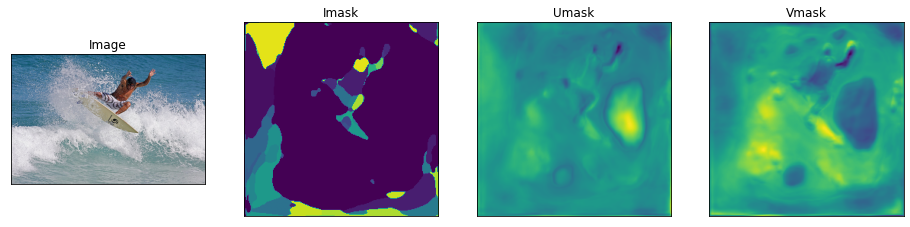

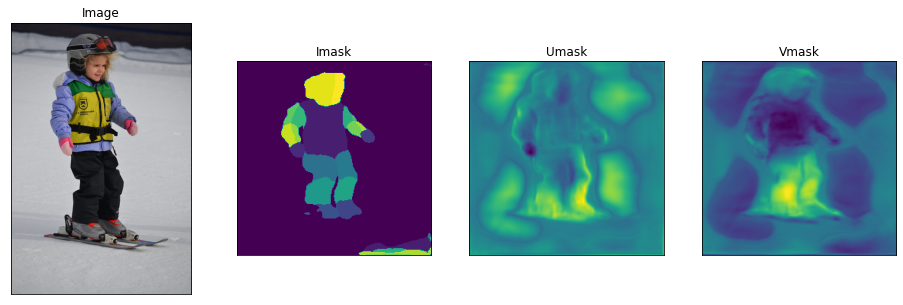

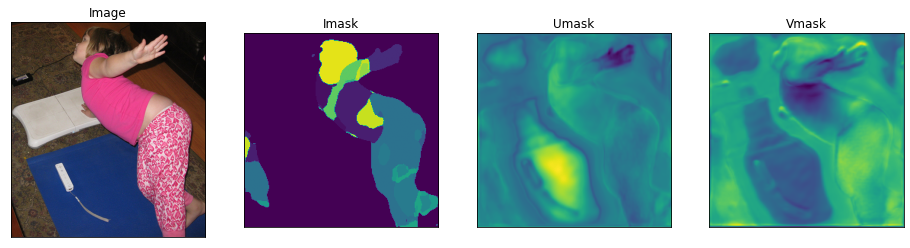

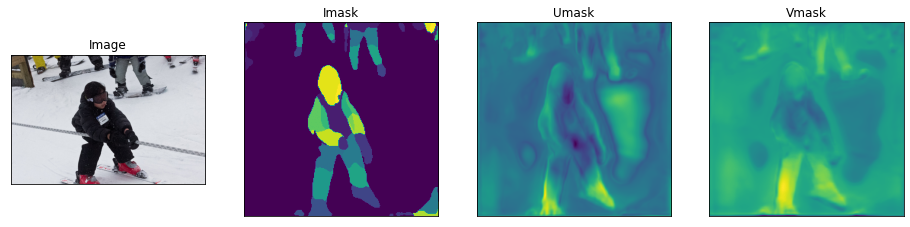

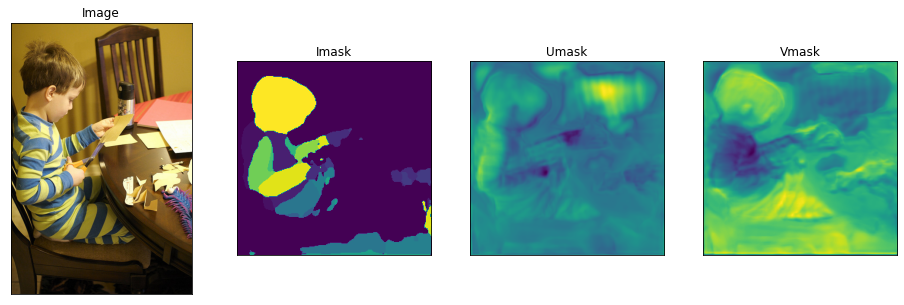

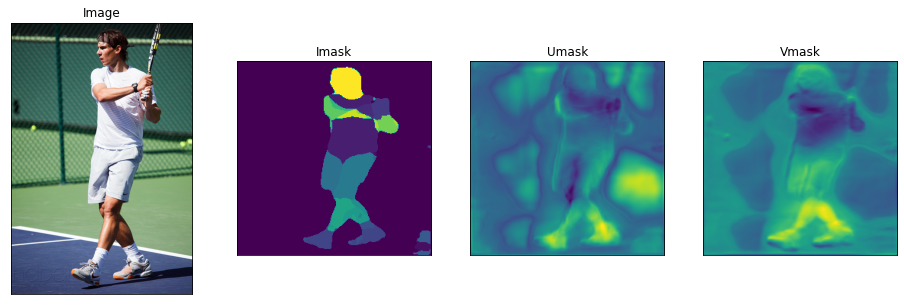

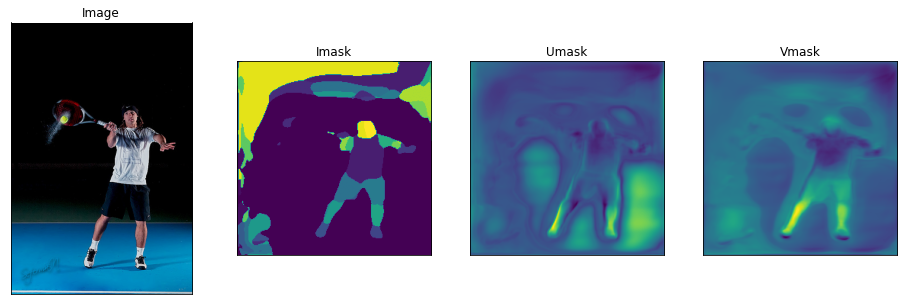

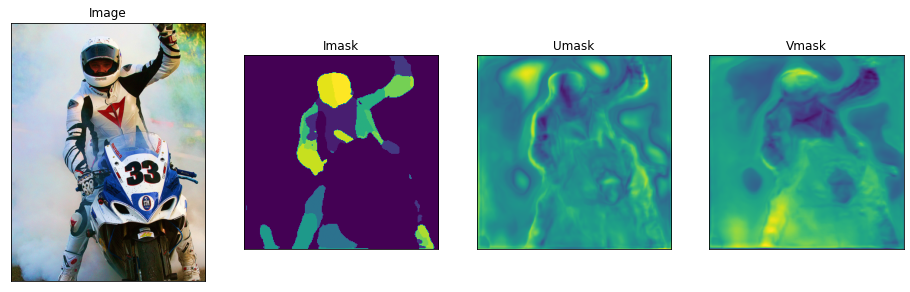

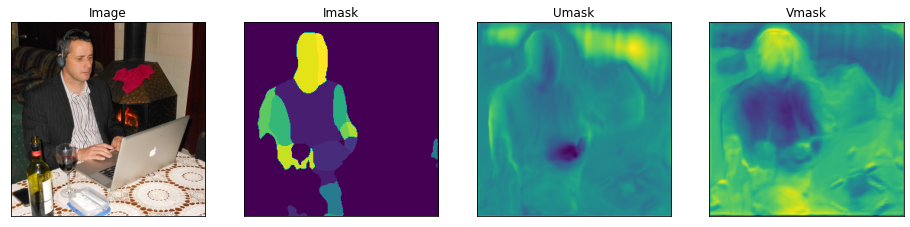

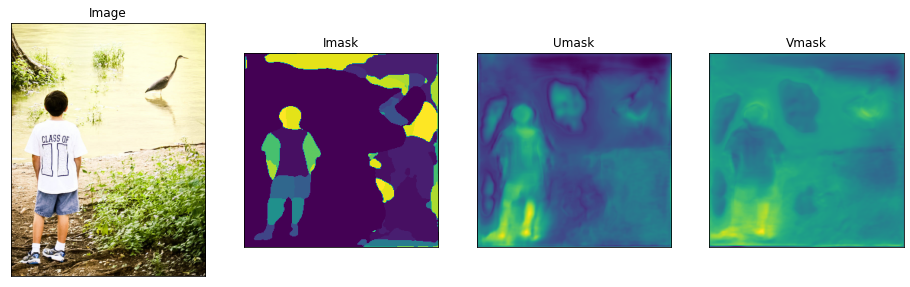

In [37]:
for i in range(len(list_files)):

    image_orig = read_image(os.path.join('checker', list_files[i]), format="RGB") 
    image = preprocessing_fn(image)
    image = np.transpose(image, [2, 0, 1])
    image = torch.tensor(image, dtype=torch.float32)
    image = torchvision.transforms.functional.resize(image, (256, 256))
    image = np.transpose(image, [1, 2, 0])

    indecies = predict[i][0:25]
    us = predict[i][25:50]
    vs = predict[i][50:75]

    iMask = drawIndeciesMask(indecies)
    uMask = drawUVMask(us, iMask)
    vMask = drawUVMask(vs, iMask)

    visualize(
        image=image_orig, 
        iMask=iMask, 
        uMask=uMask,
        vMask=vMask,
    )